# ASSIGNMENT 3-3a

In [1]:
%matplotlib widget

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import gymnasium as gym
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Video 

import warnings
warnings.filterwarnings('ignore')

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

cwd = os.getcwd()
NUM_ACTION = env.action_space.n
NUM_STATE = env.observation_space.shape

# Generate a random seed
rng = jax.random.PRNGKey(seed=1)
# Use the random seed to generate a sequence of random seeds
rngs = hk.PRNGSequence(rng)
# A new random seed is obtained by calling next(rngs)

### Definition of main useful functions

In [4]:
initializer = hk.initializers.VarianceScaling(2.0, "fan_avg", "uniform")

def q_value_layer(s_:jnp.ndarray) -> jnp.ndarray:
    """Value function approximator."""	
    q_value = hk.Sequential([
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(NUM_ACTION, w_init=hk.initializers.RandomUniform(-0.01, 0.01)),
        jnp.ravel
    ])
    return q_value(s_)

# define the neural network
nn = hk.without_apply_rng(hk.transform(q_value_layer))
# initialize the parameters
params = nn.init(rng, jnp.zeros(NUM_STATE,))
# evaluate the neural network
nn_eval = nn.apply

@jax.jit
def q_value_nn(params_:dict, s_:jnp.ndarray) -> jnp.ndarray:
    """Evaluate the neural network."""
    return nn_eval(params_, s_)

In [5]:
def pi(params_:dict, s_:jnp.ndarray, rng_:np.ndarray) -> jnp.ndarray:
    """Policy function."""
    # q(s,a) for all a in the state s
    q_val = q_value_nn(params_, s_) 
    # indices of the highest q value
    maxval = jnp.where(q_val == jnp.max(q_val))[0]
    # Take random one
    action = jax.random.choice(rng_, maxval)
    
    return action

@jax.jit
def update(params_:dict, grads_, stepsize_):
    """Update the parameters of the neural network. TD(0) update."""
    return jax.tree_map(lambda p, g: p - stepsize_ * g, params_, grads_)

@jax.jit
def loss_fn(params_:dict, s_:jnp.ndarray, a_:jnp.ndarray, r_:jnp.ndarray, gamma_:float, s1_:jnp.ndarray) -> jnp.ndarray:
    """Loss function for the neural network."""
    td_err = (r_ + gamma_ * jnp.max(q_value_nn(params_, s1_))) - q_value_nn(params_, s_)[a_]
    loss = jnp.mean(jnp.square(td_err))
    return loss

grad_fn = jax.grad(loss_fn)

In [6]:
s, _ = env.reset()

print("Initial state: ", s)
print("First Q-value for the initial state \n", q_value_nn(params, s))
print("First policy for the initial state \n", pi(params, s, next(rngs)))


Initial state:  [ 0.04886039 -0.02033514 -0.02168039 -0.02259059]
First Q-value for the initial state 
 [ 1.7675828e-05 -8.3199673e-05]
First policy for the initial state 
 0


<img src="img/assign-3/Q-FA-algo.png" alt="alt text" style="width:10cm;"/>

PARAMETERS:  

num_ep:int = 5000  
gamma:float = 0.99  
epsilon:float = 0.1  
alpha:float = 0.001  
epsilon_decay:float = 0
alpha_decay:float = 0  

In [7]:
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video","3-3a"), name_prefix="training-video", episode_trigger=lambda x: x % 250 == 0)

states = []
actions = []
kl_div = []
losses = []
ep_rewards = []
epsilons = []
next_states = []
td_errors = []
qmatrixes = []

num_ep:int = 5000 #5000
n:int = 0

gamma:float = 0.99 #0.99
epsilon:float = 0.1 #0.01
alpha:float = 0.001
epsilon_decay:float = 1e-4*0
alpha_decay:float = 1e-3*0
max_trunc_ep:int = 50

trunc_ep = 0

# Simulate
pbar = tqdm(range(num_ep))
for ep in pbar:
    
    # Update the epsilon and alpha
    epsilon_n = epsilon/(1+epsilon_decay*n)
    alpha_n = alpha/(1+alpha_decay*n)

    # Reset Env
    s = env.reset()[0]
    
    rewards = []
    # Run the episode
    for step in range(env.spec.max_episode_steps):

        # e-greedy action
        if jax.random.uniform(next(rngs)) < epsilon_n:
            a = env.action_space.sample()
        else:
            a = pi(params, s, next(rngs))

        # Update Env
        s1, r, terminated, truncated, info = env.step(int(a))

        # penalize big theta (normalized to 0.1)
        # r-= ((12 * 2 * (np.pi / 360)) - np.linalg.norm(s1[2])) / (12 * 2 * np.pi / 360)  / 10
        r -= (np.linalg.norm(s1[2]) - np.linalg.norm(s[2])) * 10
        
        if truncated:
            r += 1/(1-gamma)
            trunc_ep += 1
            # print("Truncated episode", trunc_ep)
            
        if terminated:
            r = 0
        
        rewards.append(r)
        
        losses.append(loss_fn(params, s, a, r, gamma, s1))
        grads = grad_fn(params, s, a, r, gamma, s1)
        params = update(params, grads, alpha_n)

        env.render()
        if terminated or truncated:
            break

        # Update the state before proceeding
        s = s1
    
    n += 1
    epsilons.append(epsilon_n)    
    ep_rewards.append(np.sum(rewards))
    pbar.set_description(f"Reward {np.sum(rewards)}")
    
    if trunc_ep >= max_trunc_ep:
        break

Reward 14.521978437900543: 100%|██████████| 5000/5000 [23:18<00:00,  3.57it/s]  


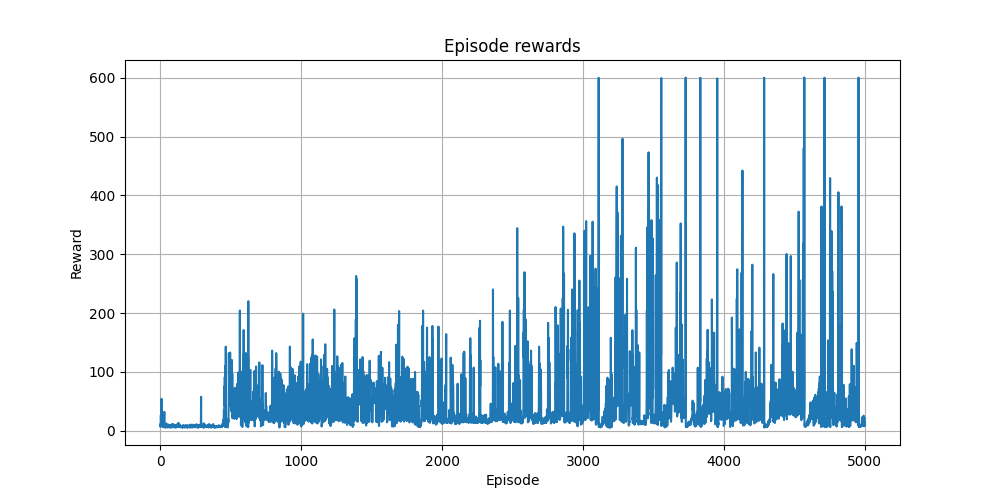

Final epsilon 0.1


In [8]:
plt.figure(figsize=(10, 5))
plt.plot(ep_rewards)
plt.title("Episode rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()

print("Final epsilon", epsilon_n)

In [9]:
env.video_folder = os.path.join(cwd,"video","3-3a")
env.name_prefix = "test-video"

# Simulate one episode with the learned policy

s = env.reset()[0]

for step in range(env.spec.max_episode_steps):
        
    a = pi(params, s, next(rngs))

    # Update Env
    s, r, done, truncated, info = env.step(int(a))

    env.render()
    if done:
        break


In [10]:
# print("Final Value Function Parameters:", params)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_Q.npz"),
#     value_params=jax.device_get(params)
# )
